In [15]:
!pip install feedparser pandas numpy matplotlib seaborn textblob-de nltk wordcloud

In [ ]:
import feedparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
import re
import string

print("Downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)
print("NLTK resources downloaded.")

NLTK resources downloaded.


In [17]:
class HeadlineFrameGame:
    def __init__(self):
        # 1. Define RSS Sources (Indian Outlets)
        self.rss_sources = {
            'The Hindu': 'https://www.thehindu.com/news/national/feeder/default.rss',
            'Times of India': 'https://timesofindia.indiatimes.com/rssfeedstopstories.cms',
            'NDTV': 'https://feeds.feedburner.com/ndtvnews-top-stories',
            'India Today': 'https://www.indiatoday.in/rss/1206578',
            'News18': 'https://www.news18.com/rss/india.xml',
            'HindustanTimes': 'https://www.hindustantimes.com/feeds/rss/trending/rssfeed.xml',
            'FirstPost': 'https://www.firstpost.com/commonfeeds/v1/mfp/rss/web-stories.xml',
            'ABP News': 'https://news.abplive.com/home/feed'
        }

        # 2. Define Recent Events (Keywords)
        self.topics = {
            'Politics/Elections': ['election', 'poll', 'bjp', 'congress', 'vote', 'modi', 'gandhi'],
            'Economy/Market': ['sensex', 'nifty', 'economy', 'inflation', 'rbi', 'gdp', 'bank'],
            'Environment/Health': ['pollution', 'smog', 'aqi', 'health', 'hospital', 'doctor', 'rain'],
            'Crime/Law': ['police', 'court', 'supreme court', 'arrest', 'case', 'justice']
        }

        self.df = pd.DataFrame()

In [18]:
def fetch_data(self):
        print("--- 📡 Fetching RSS Feeds... ---")
        all_articles = []

        for source_name, url in self.rss_sources.items():
            print(f"Reading {source_name}...")
            try:
                feed = feedparser.parse(url)
                for entry in feed.entries:
                    title = entry.get('title', '')
                    desc = entry.get('summary', '') if 'summary' in entry else entry.get('description', '')

                    # Combine title and description
                    full_text = f"{title} {desc}"

                    all_articles.append({
                        'source': source_name,
                        'title': title,
                        'text': full_text,
                    })
            except Exception as e:
                print(f"Error fetching {source_name}: {e}")

        self.df = pd.DataFrame(all_articles)
        print(f"Total articles fetched: {len(self.df)}")

        if self.df.empty:
            print("❌ No articles found.")

        return self.df

HeadlineFrameGame.fetch_data = fetch_data

In [19]:
def filter_topics_and_clean(self):
        print("\n--- 🧹 Filtering Topics & Cleaning Text... ---")

        if self.df.empty:
            print("No data to process. Run fetch_data() first.")
            return

        # 1. Assign Topics
        def assign_topic(text):
            text_lower = text.lower()
            for topic, keywords in self.topics.items():
                for k in keywords:
                    if k in text_lower:
                        return topic
            return "Other"

        self.df['topic'] = self.df['text'].apply(assign_topic)

        # Filter out 'Other'
        self.df = self.df[self.df['topic'] != 'Other'].copy()
        print(f"Articles remaining after topic filtering: {len(self.df)}")

        # 2. Clean Text
        stop_words = set(stopwords.words('english'))
        def clean_text(text):
            text = text.lower()
            text = re.sub(r'<.*?>', '', text)
            text = re.sub(r'[^\w\s]', '', text)
            words = text.split()
            words = [w for w in words if w not in stop_words]
            return " ".join(words)

        self.df['cleaned_text'] = self.df['text'].apply(clean_text)

HeadlineFrameGame.filter_topics_and_clean = filter_topics_and_clean

In [20]:
def show_topic_samples(self, samples_per_group=2):
        print(f"\n--- 🔍 Displaying Samples (Up to {samples_per_group} per Topic/Outlet) ---")

        if self.df.empty:
            print("No data to sample. Run filter_topics_and_clean() first.")
            return
        if 'topic' not in self.df.columns:
             print("Error: 'topic' column not found. Run filter_topics_and_clean().")
             return

        # Group by topic AND source, then take the top N from each group
        sample_df = self.df.groupby(['topic', 'source']).head(samples_per_group).reset_index(drop=True)

        # Set display options for clean output
        pd.set_option('display.max_colwidth', 100) # Show more of the title
        pd.set_option('display.width', 1000) # Widen the display

        # Select relevant columns for display
        display_cols = ['topic', 'source', 'title']

        if sample_df.empty:
            print("No articles found matching the specified topics.")
        else:
            # Use to_string() for better formatting in Colab
            print(sample_df[display_cols].to_string())

        # Reset options
        pd.reset_option('display.max_colwidth')
        pd.reset_option('display.width')

HeadlineFrameGame.show_topic_samples = show_topic_samples

In [21]:
def analyze_bias(self):
        print("\n--- 🧠 Analyzing Sentiment & Subjectivity... ---")

        if self.df.empty or 'text' not in self.df.columns:
            print("No data to analyze.")
            return

        sid = SentimentIntensityAnalyzer()

        def get_metrics(text):
            # VADER for Sentiment
            polarity = sid.polarity_scores(text)['compound']
            # TextBlob for Subjectivity
            subjectivity = TextBlob(text).sentiment.subjectivity
            return pd.Series([polarity, subjectivity])

        self.df[['sentiment_score', 'subjectivity_score']] = self.df['text'].apply(get_metrics)
        self.df.to_csv('processed_news_bias.csv', index=False)
        print("Analysis complete. Saved to 'processed_news_bias.csv'")

HeadlineFrameGame.analyze_bias = analyze_bias

In [22]:
def visualize(self):
        print("\n--- 📊 Generating Plots... ---")
        sns.set_theme(style="whitegrid")

        if self.df.empty:
            print("No data to visualize.")
            return

        # PLOT 1: Sentiment Distribution by Source and Topic
        plt.figure(figsize=(14, 7))
        sns.barplot(data=self.df, x='topic', y='sentiment_score', hue='source', errorbar=None, palette='viridis')
        plt.title('Average Sentiment Score by Topic and News Outlet', fontsize=16)
        plt.axhline(0, color='black', linewidth=1)
        plt.ylabel('Sentiment (Negative < 0 < Positive)')
        plt.xticks(rotation=15)
        plt.legend(title='News Source')
        plt.tight_layout()
        plt.savefig('plot_sentiment_by_topic.png')
        print("Saved plot: plot_sentiment_by_topic.png")
        plt.show()

        # PLOT 2: Subjectivity Analysis (Fact vs Opinion)
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=self.df, x='source', y='subjectivity_score', palette='coolwarm')
        plt.title('Subjectivity in Headlines (0=Fact, 1=Opinion)', fontsize=16)
        plt.ylabel('Subjectivity Score')
        plt.tight_layout()
        plt.savefig('plot_subjectivity_bias.png')
        print("Saved plot: plot_subjectivity_bias.png")
        plt.show()

        # PLOT 3: Sentiment Heatmap
        try:
            pivot_df = self.df.pivot_table(index='source', columns='topic', values='sentiment_score', aggfunc='mean')
            plt.figure(figsize=(10, 6))
            sns.heatmap(pivot_df, annot=True, cmap='RdBu', center=0, linewidths=1, linecolor='black')
            plt.title('Media Bias Heatmap: Sentiment Intensity', fontsize=16)
            plt.tight_layout()
            plt.savefig('plot_bias_heatmap.png')
            print("Saved plot: plot_bias_heatmap.png")
            plt.show()
        except Exception as e:
            print(f"Could not generate heatmap: {e}")

        # PLOT 4: Word Clouds per Topic
        print("Generating Word Clouds...")
        unique_topics = self.df['topic'].unique()

        for topic in unique_topics:
            topic_text = " ".join(self.df[self.df['topic'] == topic]['cleaned_text'])
            if len(topic_text) > 10:
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title(f'Word Cloud: {topic}', fontsize=15)
                plt.savefig(f'wordcloud_{topic.replace("/", "_")}.png')
                plt.show()

HeadlineFrameGame.visualize = visualize

In [23]:
!pip install spacy textstat
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [24]:
import spacy
import textstat
from collections import Counter

In [25]:
def analyze_ner(self):
        print("\n--- 🔬 Analyzing Named Entities (NER)... ---")

        # Load the spaCy model
        try:
            nlp = spacy.load("en_core_web_sm")
        except IOError:
            print("Error: 'en_core_web_sm' model not found.")
            print("Please run: !python -m spacy download en_core_web_sm")
            return

        if self.df.empty or 'text' not in self.df.columns:
            print("No data to analyze for NER. Run previous steps first.")
            return

        # We're interested in these entity types
        entity_labels = ['PERSON', 'ORG', 'GPE']

        entity_data = []

        # Iterate over each article
        for index, row in self.df.iterrows():
            # Process the original, uncleaned text
            doc = nlp(row['text'])

            for ent in doc.ents:
                # Check if the entity is one we care about
                if ent.label_ in entity_labels:
                    # Save the entity, its type, and the sentiment of the article it appeared in
                    entity_data.append({
                        'entity': ent.text.strip(),
                        'label': ent.label_,
                        'source': row['source'],
                        'topic': row['topic'],
                        'sentiment_score': row['sentiment_score']
                    })

        # Create a new DataFrame for all entities
        self.entity_df = pd.DataFrame(entity_data)

        if self.entity_df.empty:
            print("No relevant entities found.")
            return

        # --- Find Top Entities ---
        # We only want to plot entities that are mentioned frequently
        common_entities = [ent for ent, count in Counter(self.entity_df['entity']).most_common(15)]

        # Filter the DataFrame to only include these top entities
        self.top_entity_df = self.entity_df[self.entity_df['entity'].isin(common_entities)]

        print(f"NER analysis complete. Found {len(self.entity_df)} entities.")
        self.top_entity_df.to_csv('ner_sentiment_analysis.csv', index=False)
        print("Saved NER analysis to 'ner_sentiment_analysis.csv'")

# Add this method to the class
HeadlineFrameGame.analyze_ner = analyze_ner

In [ ]:
def analyze_readability(self):
        print("\n--- 📖 Analyzing Readability Scores... ---")

        if self.df.empty or 'text' not in self.df.columns:
            print("No data to analyze for readability.")
            return

        # Calculate Flesch Reading Ease score for each article's text
        # Higher score = easier to read
        # Lower score = harder to read (more complex language)
        try:
            self.df['readability_score'] = self.df['text'].apply(textstat.flesch_reading_ease)
            print("Readability analysis complete.")
        except Exception as e:
            print(f"Could not calculate readability: {e}")

HeadlineFrameGame.analyze_readability = analyze_readability

In [ ]:
def visualize_new_features(self):
        print("\n--- 📊 Generating New Feature Plots... ---")
        sns.set_theme(style="whitegrid")

        # --- PLOT 1: Readability Score by Outlet ---
        if 'readability_score' in self.df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=self.df, x='source', y='readability_score', palette='pastel')
            plt.title('Headline Readability by News Outlet (Higher = Easier to Read)', fontsize=16)
            plt.ylabel('Flesch Reading Ease Score')
            plt.tight_layout()
            plt.savefig('plot_readability_by_source.png')
            print("Saved plot: plot_readability_by_source.png")
            plt.show()

        # --- PLOT 2: Sentiment by Top Mentioned Entity ---
        if hasattr(self, 'top_entity_df') and not self.top_entity_df.empty:
            entity_plot_df = self.top_entity_df.groupby(['entity', 'source'])['sentiment_score'].mean().reset_index()

            plt.figure(figsize=(15, 8))
            sns.barplot(data=entity_plot_df, x='entity', y='sentiment_score', hue='source', palette='muted', dodge=True)
            plt.title('Average Sentiment for Top 15 Entities by News Outlet', fontsize=16)
            plt.ylabel('Sentiment (Negative < 0 < Positive)')
            plt.axhline(0, color='black', linewidth=1, linestyle='--')
            plt.xticks(rotation=45, ha='right')
            plt.legend(title='News Source', loc='upper right')
            plt.tight_layout()
            plt.savefig('plot_ner_sentiment_by_source.png')
            print("Saved plot: plot_ner_sentiment_by_source.png")
            plt.show()

HeadlineFrameGame.visualize_new_features = visualize_new_features

--- 📡 Fetching RSS Feeds... ---
Reading The Hindu...
Reading Times of India...
Reading NDTV...
Reading India Today...
Reading News18...
Reading HindustanTimes...
Reading FirstPost...
Reading ABP News...
Total articles fetched: 668

--- 🧹 Filtering Topics & Cleaning Text... ---
Articles remaining after topic filtering: 240

--- 🔍 Displaying Samples (Up to 2 per Topic/Outlet) ---
                 topic          source                                                                                                                    title
0            Crime/Law       The Hindu                                                               Realtor arrested for sexually harassing Kannada film actor
1            Crime/Law       The Hindu                                                 Gloom, shock grip Valley as Nowgam blast victims’ bodies reach hometowns
2   Environment/Health       The Hindu                         With 1,700 aircraft pending orders, India needs 30,000 pilots: Aviation Mini

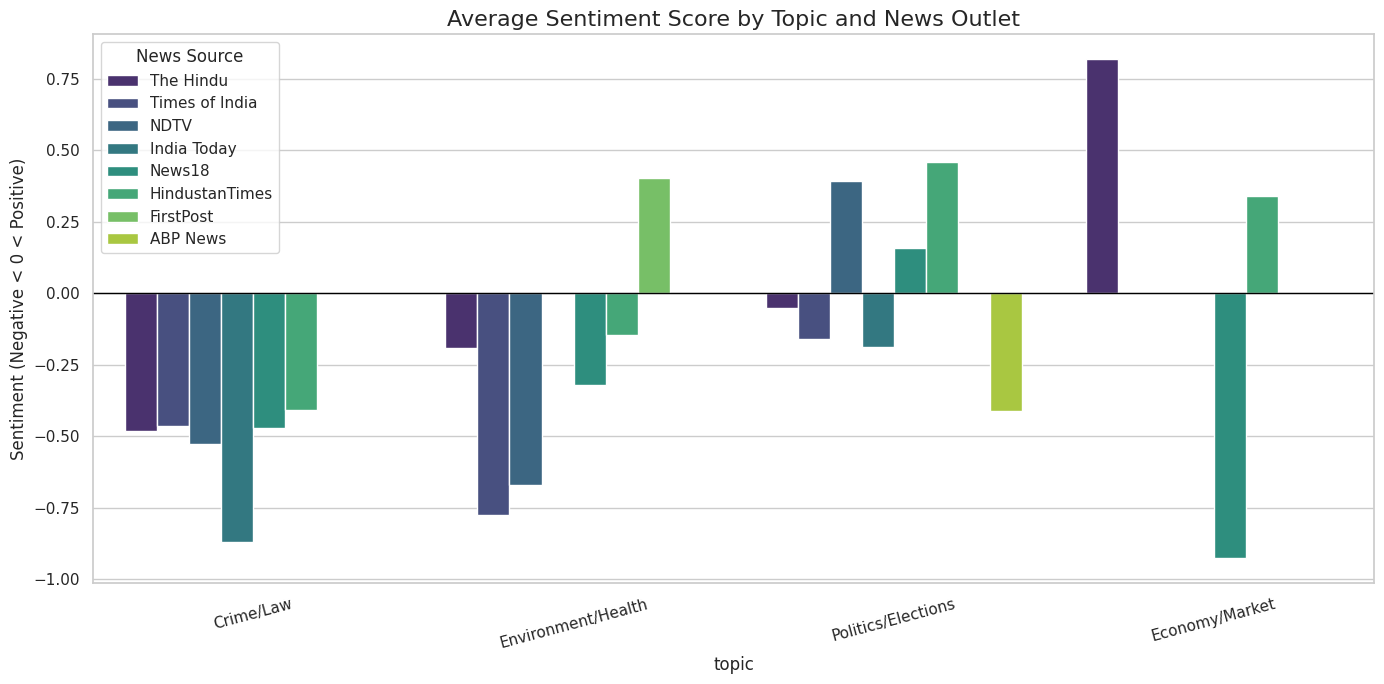

/tmp/ipython-input-3467081583.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=self.df, x='source', y='subjectivity_score', palette='coolwarm')


Saved plot: plot_subjectivity_bias.png


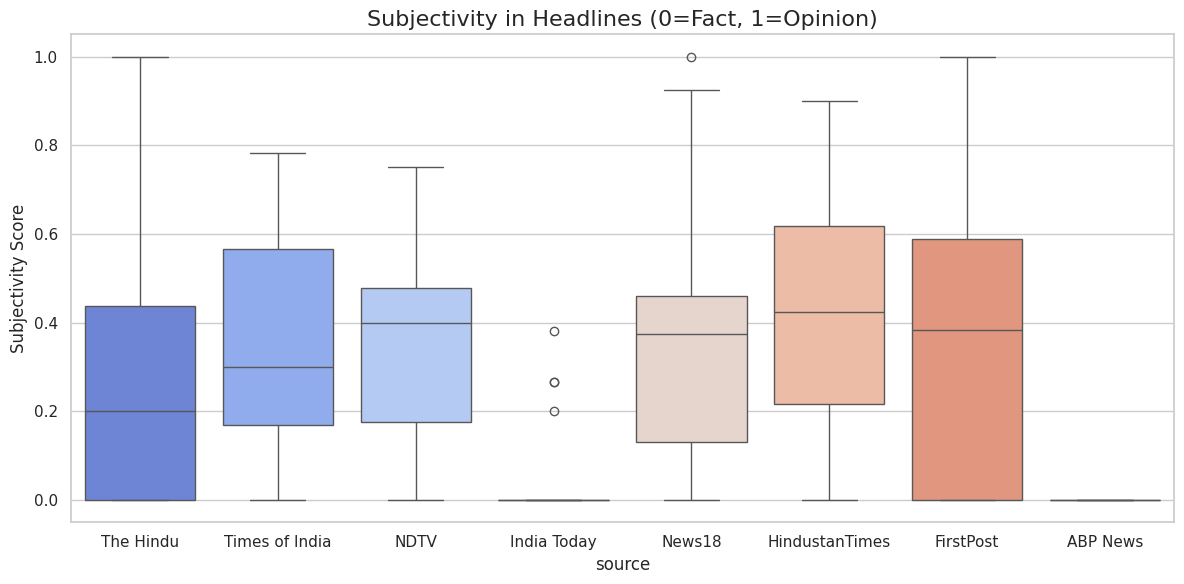

Saved plot: plot_bias_heatmap.png


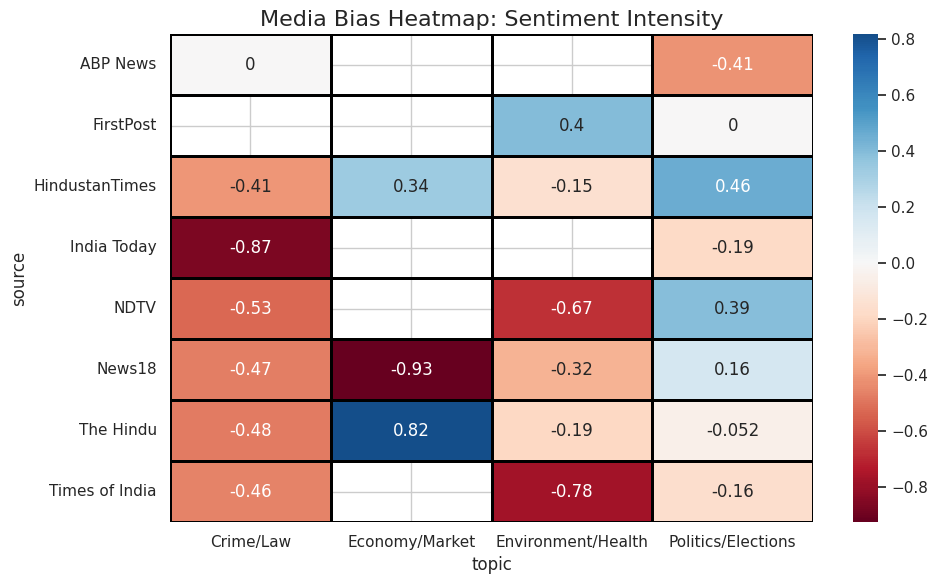

Generating Word Clouds...


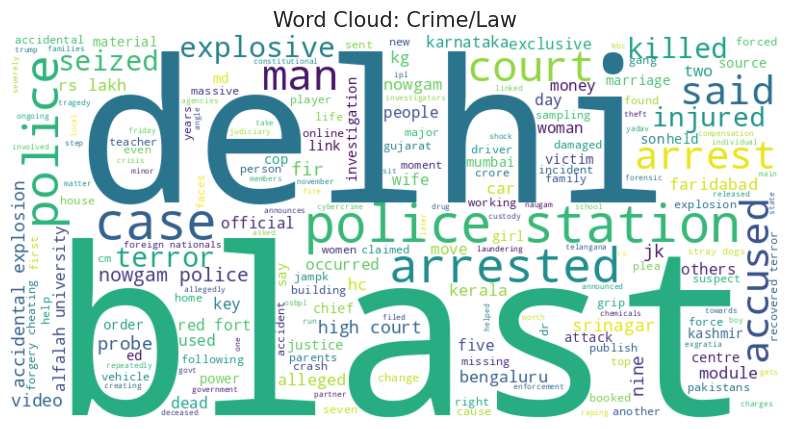

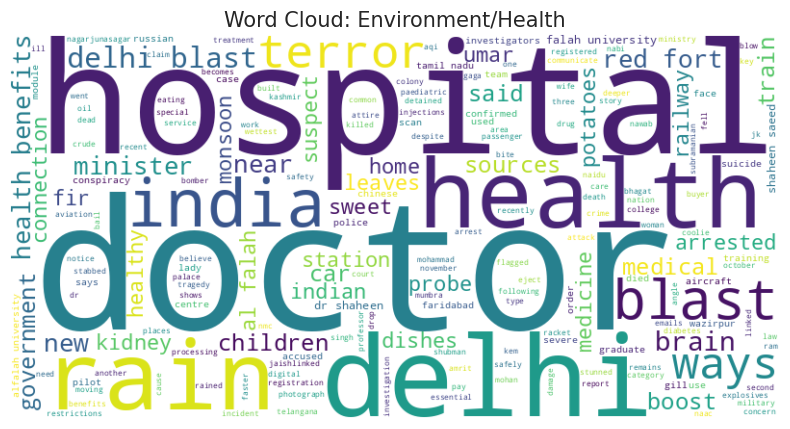

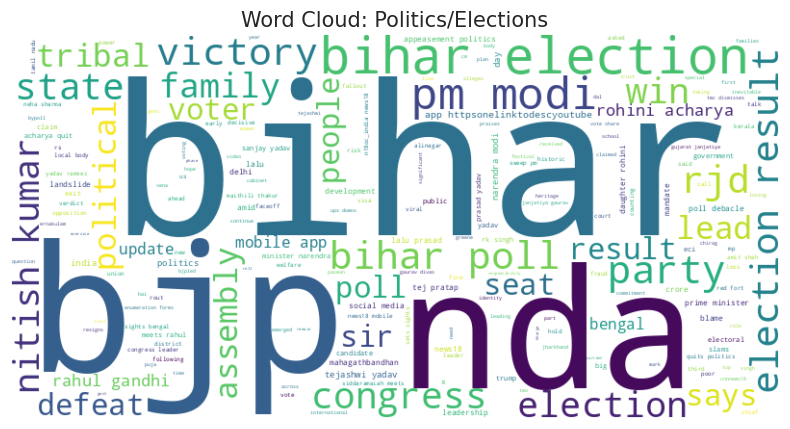

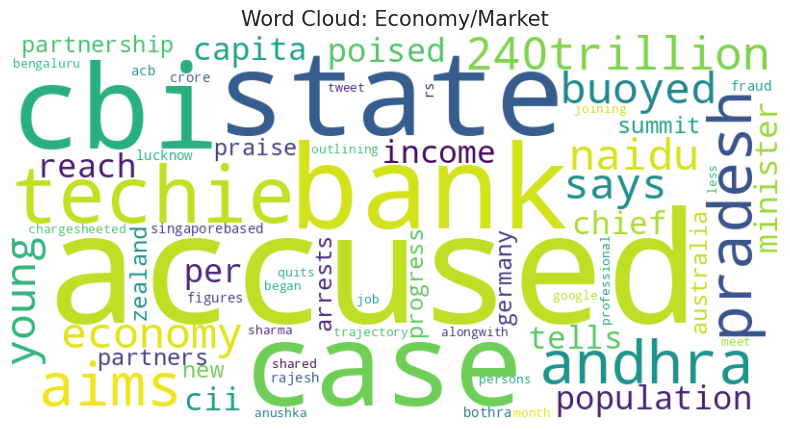


--- 📊 Generating New Feature Plots... ---


/tmp/ipython-input-2546388795.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=self.df, x='source', y='readability_score', palette='pastel')


Saved plot: plot_readability_by_source.png


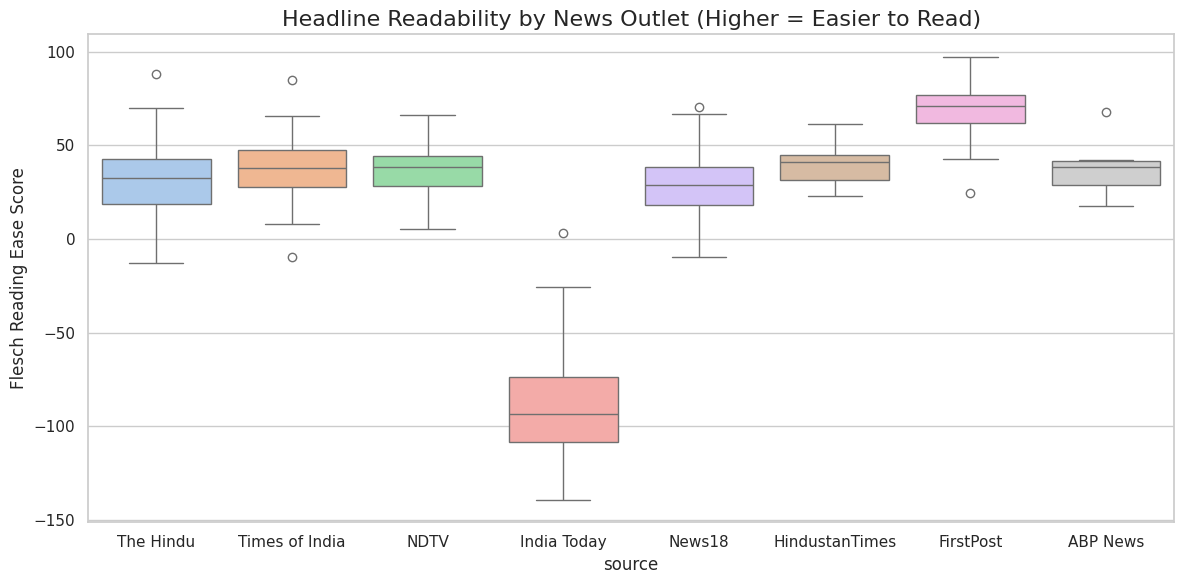

Saved plot: plot_ner_sentiment_by_source.png


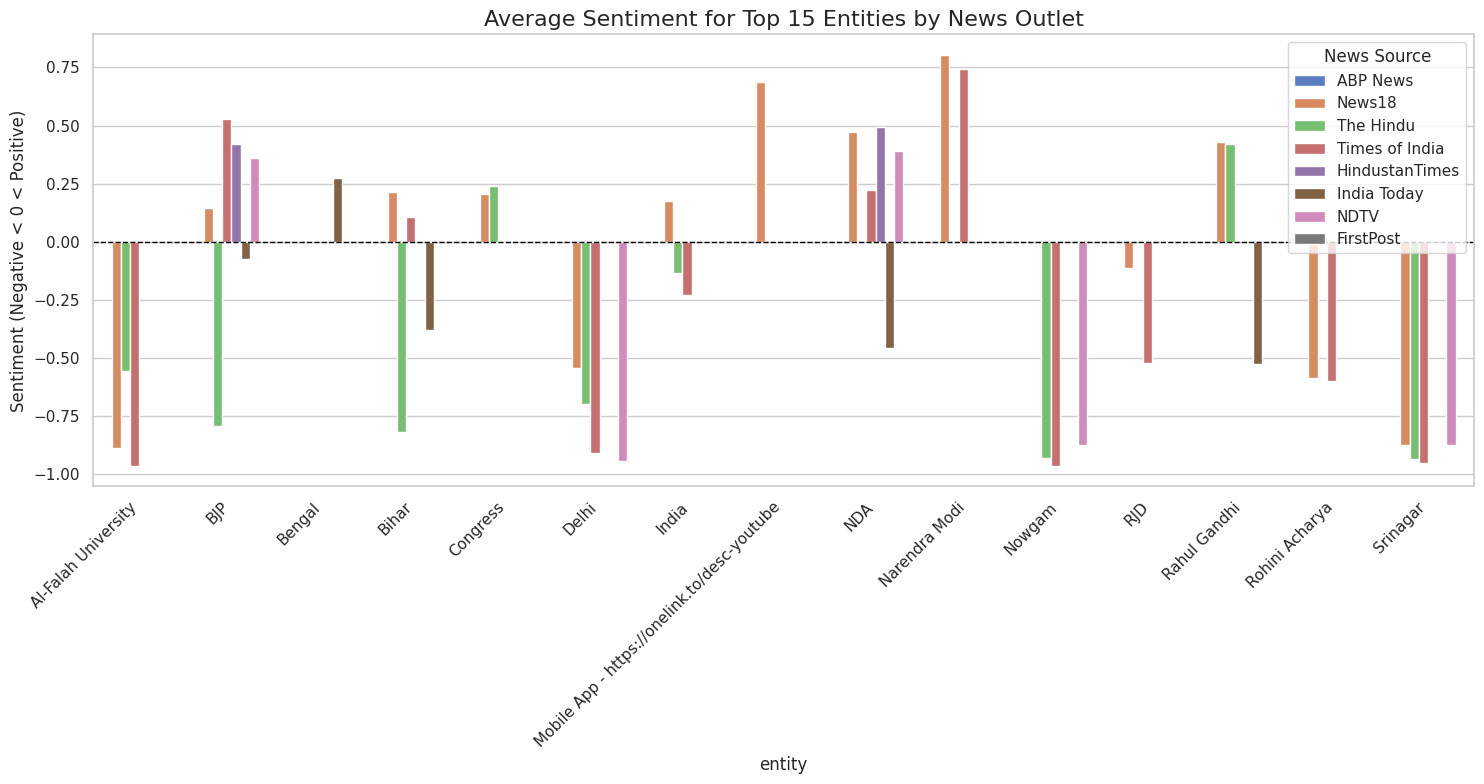


✅ The Headline Frame Game Finished Successfully with NEW features!


In [ ]:
# 1. Initialize
game = HeadlineFrameGame()

# 2. Fetch Data
game.fetch_data()

# 3. Filter and Clean 
game.filter_topics_and_clean()

# 4. Show Samples
game.show_topic_samples(samples_per_group=2)

# 5. *** OLD ANALYSIS ***
game.analyze_bias()

# 6. *** NEW ANALYSIS ***
game.analyze_ner()
game.analyze_readability()

# 7. *** VISUALIZATION  ***
game.visualize()
game.visualize_new_features()

print("\n✅ The Headline Frame Game Finished Successfully with NEW features!")